In [1]:
# Behavioural analysis

## Preparing the data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob
from matplotlib import cm
import psychopy
from psychopy.tools.filetools import fromFile

/Users/egor/Library/Enthought/Canopy_32bit/User/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Loading the data:

In [3]:
%matplotlib inline
plt.style.use('dark_background')
expName = 'mc2_tgT-mcBv_dom'
#condName = 'mc2_tgT-mcBv_peri'
dataDir = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'data/domTest/'))
print dataDir
allSubjDirs = glob.glob(dataDir + '/' + expName + '*')
print allSubjDirs
stairs = pd.DataFrame()
# matrices for intensities, responses, and means of reversals:
intns, resps, thisRevs, revMeans = [],[],[],[] 
orderInfo = pd.DataFrame() # subj, session, and stair info for ordering intns & resps

/Users/egor/Dropbox/Projects/mc/data/domTest
['/Users/egor/Dropbox/Projects/mc/data/domTest/mc2_tgT-mcBv_dom_p0_s1_2017-01-31_1047']


In [4]:
for subjDir in allSubjDirs:
    print subjDir
    subjStairsPath = glob.glob(subjDir + '/' + expName + '*.csv')[0]
    subjStairs = pd.read_csv(subjStairsPath)
    stairs = stairs.append(subjStairs)
    #print subjStairs
    for subjStairLabel in subjStairs['stairLabel']:
        #print subjStairLabel #thisSubjStair['label']
        thisStair = fromFile(subjDir + '/' + subjStairLabel + '.psydat')
        intns.append(thisStair.intensities)
        resps.append(thisStair.data)
        theseRevIntns = thisStair.reversalIntensities #detectRevs(thisStair)
        #print np.round(theseRevIntns,1)
        revMeans.append([np.average(thisStair.reversalIntensities[-4:]),
                         np.average(thisStair.reversalIntensities[-6:]),
                         np.average(thisStair.reversalIntensities[-8:])])
        orderInfo = orderInfo.append(pd.DataFrame({
                    'participant': subjStairs.participant[0],
                    'targEyeR': thisStair.extraInfo['targEyeR'],
                    'stairStart': [thisStair.extraInfo['startContr']]
                    }))
                    #'sessionLabel': os.path.basename(subjStairsPath)[:-20],
                    #'stairLabel': [subjStairLabel]
        #print np.round(thisStair.intensities,2)
        #print thisStair.data # responses (correct/incorrect)
        #print thisStair.extraInfo

/Users/egor/Dropbox/Projects/mc/data/domTest/mc2_tgT-mcBv_dom_p0_s1_2017-01-31_1047


In [5]:
targEyeList = []
for thisStairLabel in stairs.stairLabel: targEyeList.append(thisStairLabel[-1])
stairs['targEyeR'] = targEyeList
stairs['condLabel'] = 'targEyeR-' + stairs.targEyeR.astype(str)
print stairs.shape
print stairs.columns
stairs.head(5)

(4, 30)
Index([u'expName', u'expPara', u'time', u'participant', u'dom', u'session',
       u'nRevs', u'mcSz', u'mcSf', u'mcBv', u'mcBsf', u'mcPeriGap',
       u'mcPeriFade', u'targSz', u'targSf', u'targOri1', u'targOri2',
       u'targXoff1', u'targXoff2', u'targYoff', u'targV', u'targTtot',
       u'targTpeak', u'trialT', u'fixCross', u'stairLabel', u'stairStart',
       u'meanRev6', u'targEyeR', u'condLabel'],
      dtype='object')


,expName,expPara,time,participant,dom,session,nRevs,mcSz,mcSf,mcBv,...,targV,targTtot,targTpeak,trialT,fixCross,stairLabel,stairStart,meanRev6,targEyeR,condLabel
0,mc2_tgT-mcBv,dom,2017-01-31_1047,0,NaN,1,8,256,0.1,0.01,...,0,1,0.5,1,1,st-3_mcBv0.01_targTpeak0.5_targEyeR0,-3,-4.866667,0,targEyeR-0
1,mc2_tgT-mcBv,dom,2017-01-31_1047,0,NaN,1,8,256,0.1,0.01,...,0,1,0.5,1,1,st-3_mcBv0.01_targTpeak0.5_targEyeR1,-3,-1.633333,1,targEyeR-1
2,mc2_tgT-mcBv,dom,2017-01-31_1047,0,NaN,1,8,256,0.1,0.01,...,0,1,0.5,1,1,st0_mcBv0.01_targTpeak0.5_targEyeR0,0,-3.166667,0,targEyeR-0
3,mc2_tgT-mcBv,dom,2017-01-31_1047,0,NaN,1,8,256,0.1,0.01,...,0,1,0.5,1,1,st0_mcBv0.01_targTpeak0.5_targEyeR1,0,-1.866667,1,targEyeR-1


In [6]:
print np.shape(resps)
print np.shape(intns)
print np.shape(revMeans)
orderInfo = orderInfo.reset_index(drop=True)
print orderInfo.shape
orderInfo.head(5)

(4,)
(4,)
(4, 3)
(4, 3)


,participant,stairStart,targEyeR
0,0,-3,0
1,0,-3,1
2,0,0,0
3,0,0,1


Combining the trial data into a tall df.

In [7]:
nStairs = np.shape(resps)[0]
nTrials = []
for thisResp in resps: nTrials.append(np.shape(thisResp)[0])
nTrialsMax = np.max(nTrials)
allResps, allIntns = [], []
for i in range(nStairs):
    thisResp, thisIntn = resps[i], intns[i]
    x, y = np.empty((nTrialsMax,)), np.empty((nTrialsMax,))
    x[:], y[:] = np.NAN, np.NAN
    x[0:nTrials[i]] = np.array(thisResp)
    y[0:nTrials[i]] = np.array(thisIntn)
    allResps.append(x)
    allIntns.append(y)
orderInfoRepd = orderInfo.loc[np.repeat(orderInfo.index.values,nTrialsMax)]
print orderInfoRepd.shape
orderInfoRepd = orderInfoRepd.reset_index(drop=True)
orderInfoRepd['trialN'] = np.tile(np.linspace(1,nTrialsMax,nTrialsMax),nStairs)
orderInfoRepd['intns'] = np.array(allIntns).flatten()
orderInfoRepd['resps'] = np.array(allResps).flatten()
print orderInfoRepd.head(5)

(92, 3)
   participant  stairStart  targEyeR  trialN  intns  resps
0            0          -3         0     1.0   -3.0    1.0
1            0          -3         0     2.0   -4.0    1.0
2            0          -3         0     3.0   -5.0    0.0
3            0          -3         0     4.0   -4.0    1.0
4            0          -3         0     5.0   -4.0    1.0


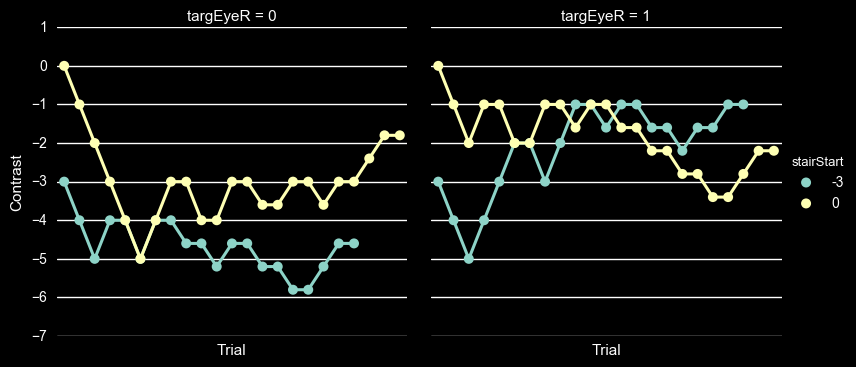

In [8]:
g = sns.factorplot(x='trialN', y='intns', hue='stairStart', col='targEyeR', data=orderInfoRepd, 
               col_wrap=2, ci=None, scale=.7)
g.set_axis_labels('Trial','Contrast')
g.set(xticks=[])
#plt.ylim(-0.1,1.1)